In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
#Constants and hyperparameters for the model, training process, and dataset are defined.
CUDA = False
DATA_PATH = './data'
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 14
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

### CUDA Availability Check and Device Setup

In [ ]:
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. This script requires a GPU.")

device = torch.device("cuda:0")

# Enable deterministic behavior for reproducibility
torch.cuda.manual_seed(seed)
cudnn.benchmark = True

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}\n")
print(f"Using device: {device}")


PyTorch version: 2.6.0+cu126
CUDA version: 12.6

Using device: cuda:0


### Data Preprocessing

In [4]:
# Load the MNIST dataset with transformations
dataset = dset.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

# Create a DataLoader for the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

### Data visualizer

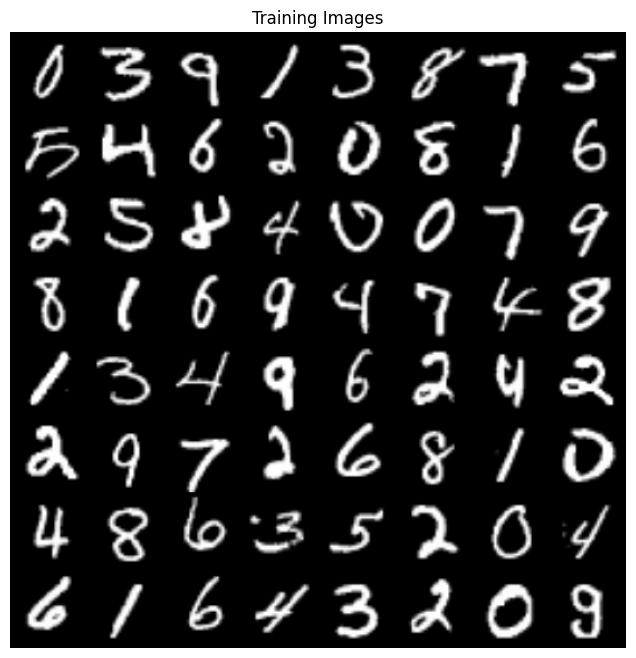

In [5]:
# Display: Visualizes a batch of real images from the dataset.
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Weight Initialization Function

In [6]:
# Weight Initialization
# Function to initialize weights of the network

# Weights_init: Initializes the weights of convolutional and batch normalization
# layers to ensure stable training of the neural networks.

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### Generator Network

In [ ]:
# Generator: Defines the Generator network architecture using transposed convolutions
# to generate images from random noise.

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input layer: From latent vector to a small “feature map”
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),

            # 1st hidden layer: Upsample to a larger feature map
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),

            # 2nd hidden layer: Further upsampling
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),

            # 3rd hidden layer: Continue upsampling
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),

            # Output layer: Produce the final image
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Outputs values in the range [-1, 1]
        )

    def forward(self, input):
        return self.main(input)


### Discriminator Network

In [ ]:
# Discriminator: Defines the Discriminator network architecture using
# convolutions to classify real and fake images.

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer: Downsample the image
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 2nd layer: Further downsampling with more channels
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # 3rd layer: Continue downsampling
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # 4th layer: Further downsample to a very small spatial dimension
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # Output layer: Produce a single number (probability)
            nn.Conv2d(D_HIDDEN * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)


### Instantiate Networks

In [9]:
#Instantiate: Creates instances of the Generator and Discriminator
#networks and applies the weight initialization function.

# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Loss Function and Optimizers

In [10]:
# Loss Function: Uses Binary Cross Entropy Loss for training.
# Optimizers: Sets up Adam optimizers for both the Generator and Discriminator networks.

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

### Training Loop

In [11]:
# Ensure CUDA is available, otherwise raise an error
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. This script requires a GPU.")

device = torch.device("cuda:0")

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop on GPU...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):

        # (1) Update the discriminator with real data
        netD.zero_grad()
        # Move batch to GPU
        real_cpu = data[0].to(device, non_blocking=True)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        noise = torch.randn((b_size, Z_DIM, 1, 1), device=device)
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # (3) Update the generator with fake data
        netG.zero_grad()
        label.fill_(REAL_LABEL)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print(f'[{epoch}/{EPOCH_NUM}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check generator output
        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise.to(device, non_blocking=True)).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop on GPU...
[0/14][0/469] Loss_D: 2.2030 Loss_G: 2.6641 D(x): 0.3701 D(G(z)): 0.5914 / 0.0940
[0/14][50/469] Loss_D: 0.0018 Loss_G: 35.8569 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[0/14][100/469] Loss_D: 0.1893 Loss_G: 8.4113 D(x): 0.9215 D(G(z)): 0.0149 / 0.0003
[0/14][150/469] Loss_D: 0.1431 Loss_G: 5.4142 D(x): 0.9546 D(G(z)): 0.0838 / 0.0061
[0/14][200/469] Loss_D: 0.1664 Loss_G: 4.5098 D(x): 0.9685 D(G(z)): 0.1170 / 0.0172
[0/14][250/469] Loss_D: 0.3773 Loss_G: 6.1366 D(x): 0.9835 D(G(z)): 0.2731 / 0.0039
[0/14][300/469] Loss_D: 0.4433 Loss_G: 3.2976 D(x): 0.8802 D(G(z)): 0.2397 / 0.0491
[0/14][350/469] Loss_D: 0.2046 Loss_G: 3.2424 D(x): 0.9243 D(G(z)): 0.1069 / 0.0555
[0/14][400/469] Loss_D: 0.2720 Loss_G: 3.1550 D(x): 0.8374 D(G(z)): 0.0718 / 0.0592
[0/14][450/469] Loss_D: 0.1492 Loss_G: 3.1019 D(x): 0.9064 D(G(z)): 0.0449 / 0.0604
[1/14][0/469] Loss_D: 3.2187 Loss_G: 3.8023 D(x): 0.9972 D(G(z)): 0.9161 / 0.0460
[1/14][50/469] Loss_D: 0.2656 Loss_G: 1.9795 D(

### Plot real and fake images

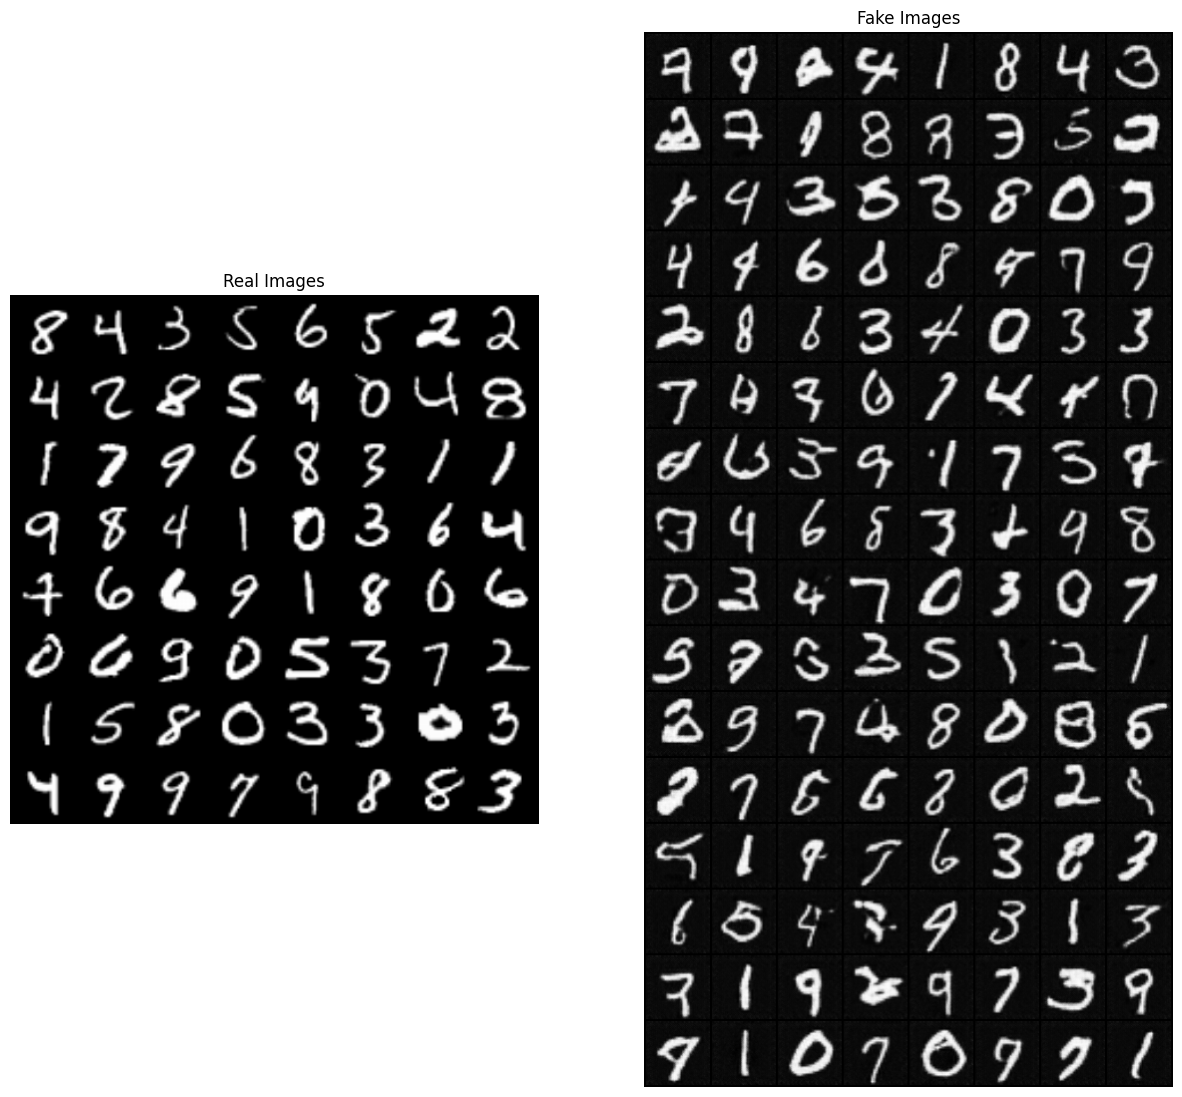

In [12]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

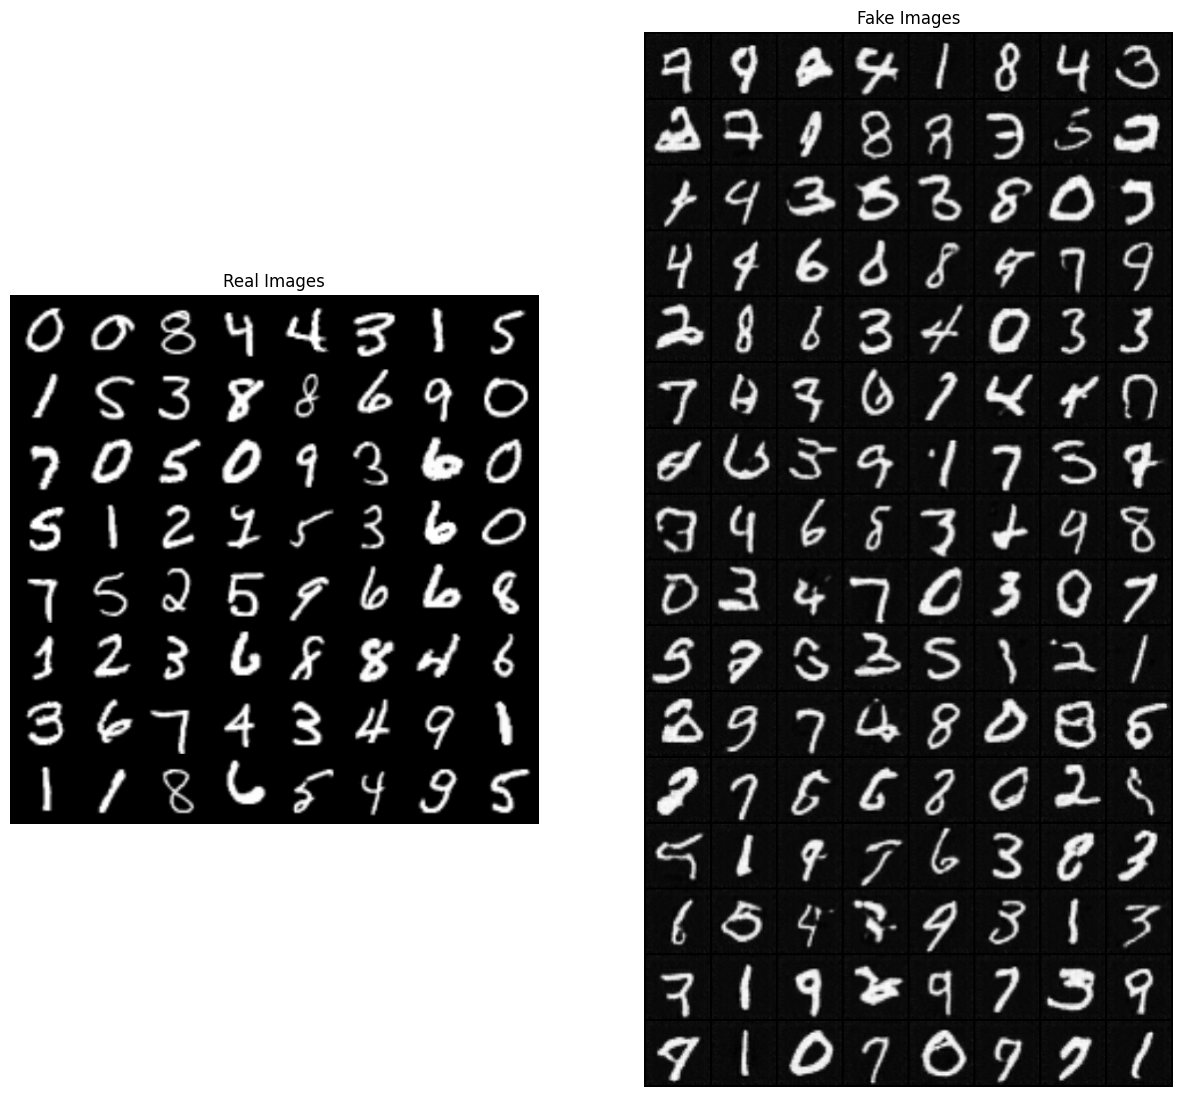

In [13]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### Save the progress as GIF

MovieWriter imagemagick unavailable; using Pillow instead.


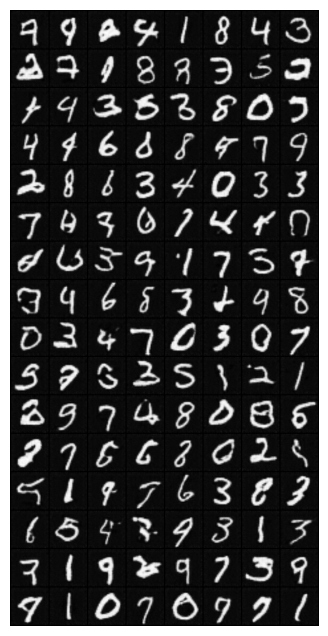

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torchvision.utils as vutils

# visualization the generated images

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(vutils.make_grid(img_list[i], padding=2, normalize=True).permute(1, 2, 0).cpu(), animated=True)] for i in range(len(img_list))]

ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)

# Save the animation as a gif
ani.save("dcgan_training.gif", writer='imagemagick')

# Show the animation
plt.show()
